<a href="https://colab.research.google.com/github/Vixuz144/Robin-Hood/blob/main/Robin_Hood%5BEN%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Problem

Suppose that in Sherwood Forest, the average radius of a tree is $R = 1m$ and the average number of trees per unit area is $\Sigma = 0.005 m^2$. If Robin Hood shoots an arrow in a random direction, how far, on average, will it travel before it strikes a tree?

#Simulation with a forest generated using a bivariate uniform distribution.

1. The first step is to define the variables involved in the problem.

* $X, Y ∼ U[-l,l]$

Where $l$ is half the length of a side of a square.

In addition, it will be assumed that all tree radii are constant; for our example, we will consider the radius to be 1.

2. In addition, the probability density functions of these two variables are:

$$ f_X(x) = \frac{1}{2l}, \quad \textrm{for } -l \leq x \leq l, \ x\in\mathbb{R} $$

$$ f_Y(y) = \frac{1}{2l}, \quad \textrm{for } -l \leq y \leq l, \ y\in\mathbb{R} $$

3. And the cumulative density functions of both variables are:

$$ F_X(x) = \frac{x+l}{2l}, \quad \textrm{para } -l \leq x \leq l, \ x\in\mathbb{R} $$

$$ F_Y(y) = \frac{y+l}{2l}, \quad \textrm{para } -l \leq y \leq l, \ y\in\mathbb{R} $$

4. With all this, we can move on to generate the trees of Sherwood Forest and perform the arrow launch. For this, we will use the following function.

In [1]:
from random import random, seed
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from numba import jit

In [2]:
@jit(nopython = True)
def bosque_flecha(a, b, ra, n):
  X = a+(b-a)*np.random.random(n)
  Y = a+(b-a)*np.random.random(n)

  pos = np.equal(X>0, True*np.ones(n))
  R = ra * np.ones_like(Y)
  X_pos, Y_pos, R_pos = X[pos], Y[pos], R[pos]

  s = np.argsort(X_pos)
  Xf, Yf, Rf = X_pos[s], Y_pos[s], R_pos[s]
  n = len(Yf)

  x, y, r = 0, 0, 0
  for i in range(n):
    if abs(Yf[i]) <= Rf[i]:
      x, y, r = Xf[i], Yf[i], Rf[i]
      break
  if x != 0 or y!= 0:
    d = x - np.sqrt(r**2 - y**2)
  else:
    d = b
  return X, Y, x, y, d

This function generates the positions of the of the tree centers using two uniform distributions in $[a, b]$. It also provides the constant radii of the trees and simulates the launch of an arrow in the positive $x$ axis.

* Input:
  * a: lower limit of the uniform distribution.
  * b: upper limit of the uniform distribution.
  * ra: trees constant radius.
  * n: number of trees to generate.


* Output:
  * X: list of the x coordinates of the tree centers.
  * Y: list of the y coordinates of the tree centers.
  * x: float, x coordinate of the center of the tree that was hit by the arrow.
  * y: float, y coordinate of the center of the tree that was hit by the arrow.
  * d: float, distance traveled by the arrow until it hit a tree.

5. Now, let's see the function in action. For this, we will consider a density of $0.005\frac{\textrm{trees}}{m^2}$ to the simulation, and the radii of the trees are a constant 1.

To generate the number of trees based on the tree density parameter per area, it is necessary to isolate the interval width (forest radius).

In [3]:
ρ = 0.005
r = 400
d = 2*r
n = int(ρ*d**2)

In [4]:
# ρ = 0.005
# n = 1000
# r = ρ*n/2

The following presents a forest graph. The white point represents the origin, the green points denote the trees, and the red point indicates the tree that was impacted by the arrow.

The arrow struck the tree with coordinates (118.32983621085975,-0.4684775139645012). The arrow traveled 117.44636079020016m


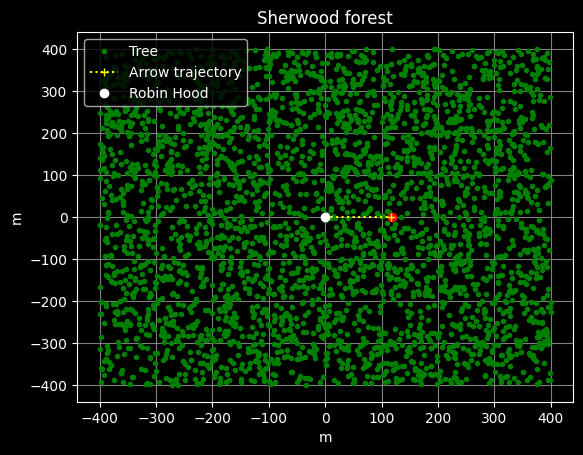

In [5]:
ra = 1
X, Y, x, y, d = bosque_flecha(-r, r, ra, n)

print(f'The arrow struck the tree with coordinates ({x},{y}). The arrow traveled {d}m')

plt.style.use('dark_background')

plt.plot(X,Y, '.g', label='Tree')
plt.plot(x,y, 'or')
plt.plot((0,d), (0,0), ':+', color = 'yellow', label='Arrow trajectory')
plt.plot(0,0, 'ow', label='Robin Hood')
plt.title('Sherwood forest')
plt.xlabel('m')
plt.ylabel('m')
plt.grid(color='gray')
plt.legend()

plt.savefig('First_graf')
plt.show()

6. Once we have the simulation of a shot, we need only to repeat the shots multiple times to observe the behavior of the process through the Monte Carlo method, allowing us to reach a steady state of the simulation. To achieve this, we will employ the following function.

In [6]:
@jit(nopython = True)
def experimento(ρ, r, ra=1, n = 10**4):
  na = int(ρ*(2*r)**2)
  l = []
  for i in range(n):
    d = bosque_flecha(-r, r, ra, na)[-1]
    l.append(d)
  return l

We set the function inputs.

In [7]:
densidad = 0.005
r = 400
ra = 1
n = 10**3

The function is executed, and a confidence interval is determined for the expected value of the distance traveled by the arrow until impact.

In [8]:
l = experimento(densidad, r, ra, n)

In [9]:
m = np.mean(l)
ds = np.std(l, ddof=1)
z = norm.ppf(0.975)
print(f'The 95% confidence interval is [{m - z*ds/np.sqrt(n)}, {m + z*ds/np.sqrt(n)}]')

The 95% confidence interval is [94.9729330275977, 106.83950144109356]


7. Furthermore, to better visualize the results of the Monte Carlo simulation, the following graph is presented to illustrate the transient state and the steady state of the simulation as the iterations progress."

In [10]:
@jit(nopython = True)
def graf(l, p=1):
  ls = []
  for i in range(1,n):
    a = np.array(l[:i:p])
    ls.append(a.mean())

  return ls

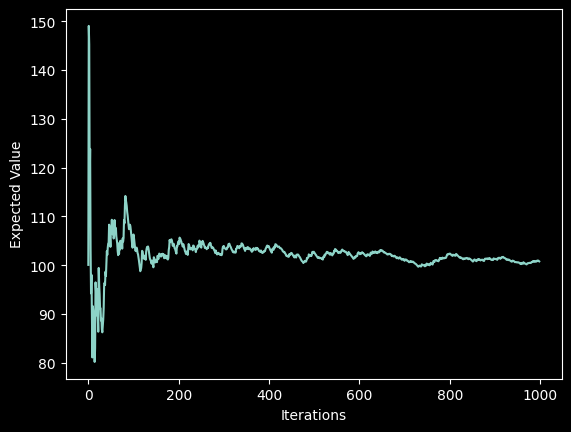

In [11]:
ls = graf(l)

plt.plot(ls)
plt.xlabel('Iterations')
plt.ylabel('Expected Value')
plt.savefig('Second_graf')
plt.show()

8. Finally, the experiment is repeated several times to obtain the mean of the sample means, which will serve as the most accurate estimate of the average distance the arrow will travel until it impacts a tree. In addition, a confidence interval with a confidence level of 95% is given.

In [12]:
@jit(nopython = True)
def rep(ρ, r, ra, n = 10**3, n_rep = 10**2):
  l = []
  for i in range(n_rep):
    d = experimento(ρ, r, ra, n)
    D = np.array(d)
    l.append(D.mean())
  return l

In [13]:
nr = 10**3
l = rep(densidad, r, ra, 400, nr)

In [14]:
m = np.mean(l)
ds = np.std(l, ddof=1)
z = norm.ppf(0.975)
li = m - z*ds/np.sqrt(nr)
ls = m + z*ds/np.sqrt(nr)
print(f'The 95% confidence interval is [{li}, {ls}]')
print(f'The expected value of the distance traveled by the arrow = {m}m')

The 95% confidence interval is [97.26373752807734, 97.84160327618102]
The expected value of the distance traveled by the arrow = 97.55267040212918m


Finally, a histogram is included to visualize the behavior of the experiment repetitions, resulting in an approximate Gaussian bell curve.

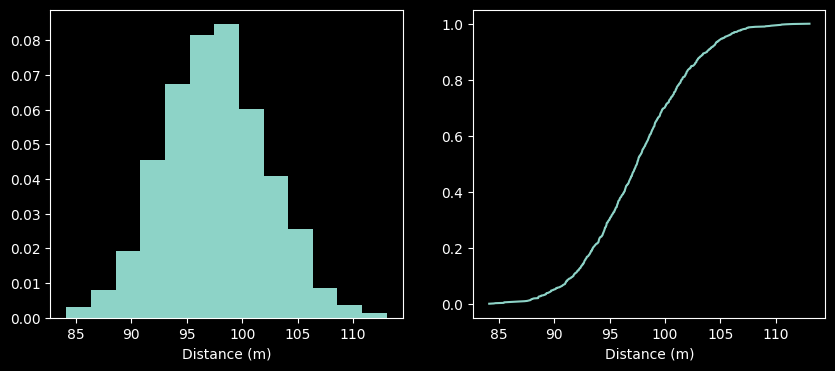

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].hist(l, bins=13, density=True)
ax[0].set_xlabel('Distance (m)')
ax[1].plot(np.sort(l), np.linspace(0, 1, nr))
ax[1].set_xlabel('Distance (m)')
fig.show()

#Simulation with a forest generated using a bivariate Poisson process with a forest radius and constant tree radii.

1. The first step is to define the variables involved in the problem. To achieve this, the variables will be represented in polar coordinates prior to their transformation into cartesian coordinates.

* $Θ ∼ Exp[λ]$
* $R ∼ U[0,\mathcal{R}]$

where $\mathcal{R}$ is the radius of a circle within which the positions of the trees will be generated, and $λ$ is the parameter of the Poisson process, which in our context represents the density of trees in Sherwood Forest.


The Poisson process that expresses the location of the trees in Sherwood Forest will be generated from these two parameters.

2. In addition, the probability density functions of these two variables are:

$$ f_Θ(θ) = λe^{-λθ}, \quad \textrm{para } θ \geq 0, \ θ\in\mathbb{R} $$
$$ f_R(r) = \frac{1}{\mathcal{R}}, \quad \textrm{para } r \in [0, \mathcal{R}], \ r\in\mathbb{R} $$



3. And the cumulative density functions of both variables are:



$$ F_Θ(θ) = 1 - e^{-λθ}, \quad \textrm{para } θ \geq 0, \ θ\in\mathbb{R} $$
$$ F_R(r) = \frac{r}{\mathcal{R}}, \quad \textrm{para } r \in [0, \mathcal{R}], \ r\in\mathbb{R} $$

4. With all this, we can proceed to generate the trees. For this purpose, we will use the following function.

In [16]:
from random import random
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from numba import jit

In [17]:
@jit(nopython = True)
def bosque(r, ρ):
  n = 0
  X = []
  while sum(X) <= np.pi*r**2:
    n += 1
    X.append(-np.log(random())/ρ)

  R, θ = [], []
  i = 1
  while n>1 and i<n:
    R.append(np.sqrt(sum(X[:i])/np.pi))
    θ.append(2*np.pi*random())
    i += 1

  return R, θ

This function generates the bivariate Poisson process.

* Inputs:
  * r: Radius of the circle within which the trees will be generated. It must be a positive float.
  * ρ: Parameter of the Poisson process (λ). Average density of trees in Sherwood Forest. It must be a positive float.


* Outputs:
  * X: List of the x coordinates of the trees.
  * Y: List of the y coordinates of the trees

5. Now, let's observe the execution of the function. For this, we will consider a $100m$ radius and a density of $0.005\frac{\textrm{árboles}}{m^2}$ for the simulation

In [18]:
radio = 100
densidad = 0.005

In [19]:
seed(144)
R, θ = bosque(radio, densidad)
X = R*np.cos(θ)
Y = R*np.sin(θ)

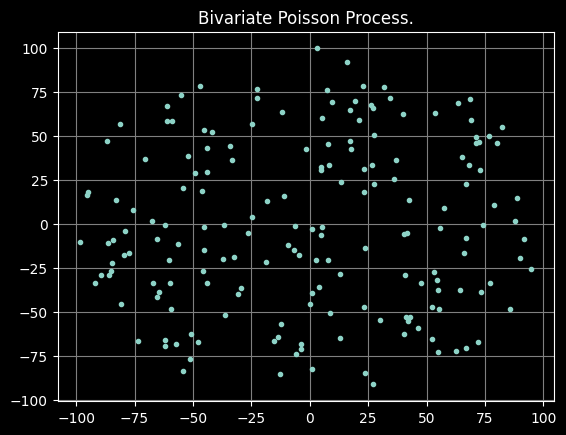

In [20]:
plt.style.use('dark_background')
plt.plot(X,Y, '.')
plt.title('Bivariate Poisson Process.')
plt.grid(color='gray')
plt.show()

6. Implementation of the archer, Robin Hood.

At this point, we have a small part of our simulation set up. Now, let's introduce our co-protagonist of the problem, Robin Hood. For this, we will consider that this famous archer is located at the center of our Sherwood Forest. When he launches an arrow in a random direction, it may hit and become lodged in a tree. The question now is: how will we determine whether the arrow is embedded in the tree or not?

To determine this, we need to know the dimensions of the tree. For now, let us assume that the trunk of the tree is a cylinder with radius $r_a$. Therefore, if the direction of the arrow intersects with a circle of radius $r_a$ centered at the coordinates of a tree, it will have hit the tree, and we will state that this is where the arrow came to rest after the shot.

To code this, we will use some clever tricks to save computational resources.

* First, instead of shooting an arrow in a random direction, we will shoot it in the direction of the positive $x$ axis, that is, in the direction $(1,0)$. This is because generating a random forest each time will be akin to having chosen a direction due to the pseudo-randomness of the Poisson process.


* With this implementation, we only need to decide when the arrow has struck a tree. To do this, we will discard all trees with negative x-coordinates, as the arrow cannot reach them unless it bounces.

* Next, instead of calculating the circumference of each tree, we will simply check if the arrow is close enough to the trees. We will compare the radius of each tree at the semicircle with the distance from the center of the tree (coordinates generated by the Poisson process) to the arrow. If the distance is less than the radius, the arrow will have struck; if the distance is greater than the radius, the arrow will not have struck.

* The final trick is how to calculate the distance from the center of the tree to the arrow, which will be straightforward since we take the direction of the arrow as the positive $x$ axis. This allows us to disregard the $x$ coordinate of both the tree and the arrow, resulting in the distance being the absolute value of the $y$ coordinate of the tree.

The only thing left before coding these tricks will be to consider that the arrow stops when it strikes the first tree. So, Robin will need to head over to that tree to get his arrow back if he wants it.

In [21]:
@jit(nopython = True)
def disparo_flecha(X, Y, R, max_dist):
  # X, Y = np.array(abscisas), np.array(ordenadas)
  n = len(X)

  pos = np.equal(X>0, True*np.ones(n))
  X_pos, Y_pos, R_pos = X[pos], Y[pos], R[pos]

  s = np.argsort(X_pos)
  X, Y, R = X_pos[s], Y_pos[s], R_pos[s]
  n = len(Y)

  x, y, r = 0, 0, 0
  for i in range(n):
    if abs(Y[i]) <= R[i]:
      x, y, r = X[i], Y[i], R[i]
      break
  if x != 0 or y!= 0:
    d = x - np.sqrt(r**2 - y**2)
  else:
    d = max_dist
  return x, y, d

The arrow struck the tree with coordinates (73.95275473840343,-0.6301481767429271). The arrow traveled 73.17627983517245m


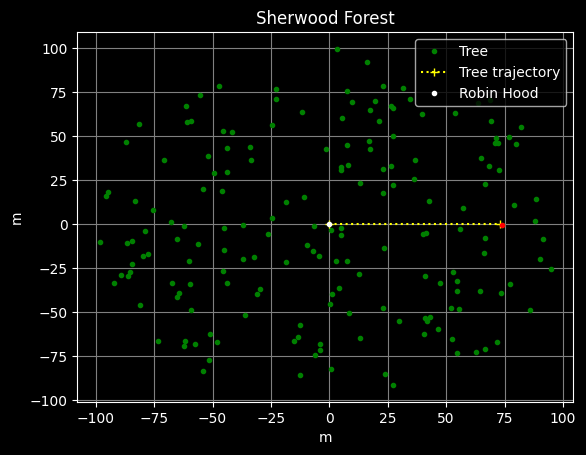

In [22]:
r_a = 1 * np.ones(len(X))
x, y, d = disparo_flecha(X, Y, r_a, radio)

print(f'The arrow struck the tree with coordinates ({x},{y}). The arrow traveled {d}m')

plt.plot(X, Y, '.g', label='Tree')
plt.plot((0,d), (0,0), ':+', color = 'yellow', label='Tree trajectory')
plt.plot(x, y, '.r')
plt.plot(0, 0, '.w', label='Robin Hood')
plt.title('Sherwood Forest')
plt.xlabel('m')
plt.ylabel('m')
plt.grid(color='gray')
plt.legend()

plt.savefig('Third_graf')
plt.show()

7. Now that we have the simulation of a shot, we just need to repeat the shots multiple times to observe the behavior of the process. This will allow us to reach a steady state of the simulation. To achieve this, we will use the following function.

In [23]:
def experimento(R, ρ, r_a, n = 10**4):
  l = []
  for i in range(n):
    r, t = bosque(R, ρ)
    x = r*np.cos(t)
    y = r*np.sin(t)
    lra = r_a * np.ones(len(x))
    _, _, d = disparo_flecha(x, y, lra, R)
    l.append(d)
  return l

In [24]:
radio = 320
densidad = 0.005
r_a = 1
n = 10**3

In [25]:
l = experimento(radio, densidad, r_a, n)

In [26]:
m = np.mean(l)
d = np.std(l, ddof=1)
z = norm.ppf(0.975)
print(f'The 95% confidence interval is [{m - z*d/np.sqrt(n)}, {m + z*d/np.sqrt(n)}]')

The 95% confidence interval is [89.76444736488533, 100.14387601921071]


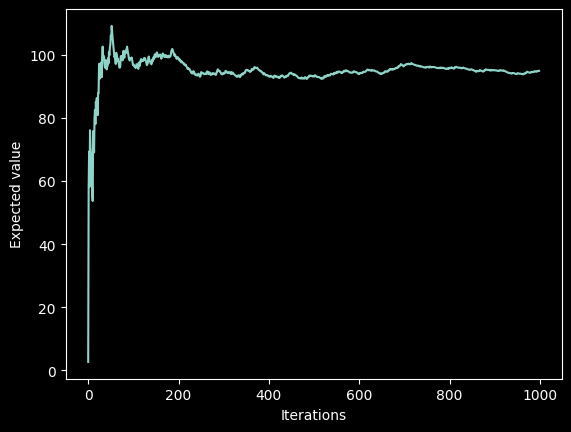

In [27]:
@jit(nopython = True)
def graf(l, p=1):
  ls = []
  for i in range(1,n):
    a = np.array(l[:i:p])
    ls.append(a.mean())

  return ls

ls = graf(l)

plt.plot(ls)
plt.xlabel('Iterations')
plt.ylabel('Expected value')
plt.savefig('Fourth_graf')
plt.show()

However, limiting the bivariate Poisson process to a circle of radius $\mathcal{R}=320$ has the consequence that in some shots the arrow exits the circle, which we can interpret as the arrow traveling more than 320 m. So, a little recounting shows that...

In [28]:
print(f'... there is a {100 * l.count(radio)/len(l)}% of arrows that travel {radio}m and do not hit any tree')

... there is a 3.6% of arrows that travel 320m and do not hit any tree


8. Finally, we repeat the experiment multiple times to find the mean of the sample means, which will be the closest estimate of the average distance the arrow will travel until it collides.

In [29]:
def rep(R, ρ, r_a, n = 10**3, n_rep = 10**2):
  l = []
  for i in range(n_rep):
    d = experimento(R, ρ, r_a, n)
    D = np.array(d)
    l.append(D.mean())
  return l

In [30]:
nr = 400
l = rep(radio, densidad, r_a, n = 400, n_rep = nr)

In [32]:
m = np.mean(l)
d = np.std(l, ddof=1)
z = norm.ppf(0.975)
print(f'The 95% confidence interval is [{m - z*d/np.sqrt(nr)}, {m + z*d/np.sqrt(nr)}]')
print(f'And the expected value of the distance traveled by the arrow is {m}m')

The 95% confidence interval is [94.45635949901522, 95.28997729183452]
And the expected value of the distance traveled by the arrow is 94.87316839542487m


In addition, a couple of graphs are included that illustrate the nature of the behavior of the distance traveled by the arrow throughout the repetitions of the experiment.

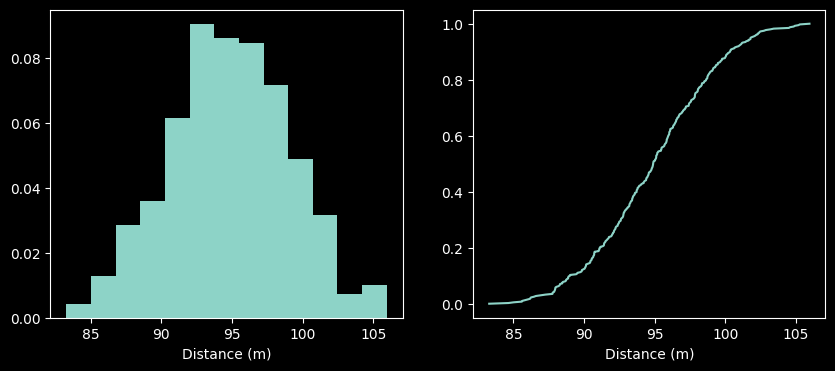

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].hist(l, bins=13, density=True)
ax[0].set_xlabel('Distance (m)')
ax[1].plot(np.sort(l), np.linspace(0, 1, nr))
ax[1].set_xlabel('Distance (m)')
fig.show()

#Simulation with a forest generated using a bivariate Poisson process with a forest radius and uniform tree radii.

1. The first step is to define the variables involved in the problem. To achieve this, the variables will be represented in polar coordinates prior to their transformation into cartesian coordinates.

* $Θ ∼ Exp[λ]$
* $R ∼ U[0,\mathcal{R}]$

where $\mathcal{R}$ is the radius of a circle within which the positions of the trees will be generated, and $λ$ is the parameter of the Poisson process, which in our context represents the density of trees in Sherwood Forest.


The Poisson process that expresses the location of the trees in Sherwood Forest will be generated from these two parameters.


Moreover, a uniform distribution will be considered in $[0,2]$ for the radii of the trees.

* $r_a ∼ U(0, 2) $

2. In addition, the probability density functions of these three variables are:

$$ f_Θ(θ) = λe^{-λθ}, \quad ∀ θ \geq 0, \ θ\in\mathbb{R} $$

$$ f_R(r) = \frac{1}{\mathcal{R}}, \quad ∀ r \in [0, \mathcal{R}], \ r\in\mathbb{R} $$

$$ f_{r_a}(x) = \frac{1}{2}, \quad ∀ x \in [0, 2], \ x\in\mathbb{R} $$



3. And the cumulative density functions of these variables are:



$$ F_Θ(θ) = 1 - e^{-λθ}, \quad ∀ θ \geq 0, \ θ\in\mathbb{R} $$

$$ F_R(r) = \frac{r}{\mathcal{R}}, \quad ∀ r \in [0, \mathcal{R}], \ r\in\mathbb{R} $$

$$ F_{r_a}(x) = \frac{x}{2}, \quad ∀ x \in [0, 2], \ x\in\mathbb{R} $$

4. Given all this, we can now proceed to generate the trees. To this end, we shall utilize the following function.

In [34]:
from random import random
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from numba import jit

In [35]:
@jit(nopython = True)
def bosque(r, ρ):
  n = 0
  X = []
  while sum(X) <= np.pi*r**2:
    n += 1
    X.append(-np.log(random())/ρ)

  R, θ = [], []
  i = 1
  while n>1 and i<n:
    R.append(np.sqrt(sum(X[:i])/np.pi))
    θ.append(2*np.pi*random())
    i += 1

  return R, θ

  This function generates the bivariate Poisson process.

* Inputs:
  * r: Radius of the circle within which the trees will be generated. It must be a positive float.
  * ρ: Parameter of the Poisson process (λ). Average density of trees in Sherwood Forest. It must be a positive float.


* Outputs:
  * X: List of the x coordinates of the trees.
  * Y: List of the y coordinates of the trees

In addition, to generate the radii of the trees, we will use the following function.

In [36]:
@jit(nopython = True)
def radios_unif(n, a = 0, b = 2):
  return a + (b-a) * np.random.random(n)

This function generates an array of radii with a uniform distribution.
* Inputs:
  * n:number of random values to generate, representing the number of trees.
  * a: lower limit of the interval to generate random numbers, the smallest radius that can be obtained.
  * b: upper limit of the interval to generate random numbers, the largest radius that can be obtained.

* Outputs:
  * r_a: List of the tree radii with a uniform distribution.

5. Now, let's observe the execution of the function. For this, we will consider a $100m$ radius and a density of $0.005\frac{\textrm{árboles}}{m^2}$ for the simulation

In [37]:
radio = 100
densidad = 0.005

In [38]:
R, θ = bosque(radio, densidad)
X = R*np.cos(θ)
Y = R*np.sin(θ)

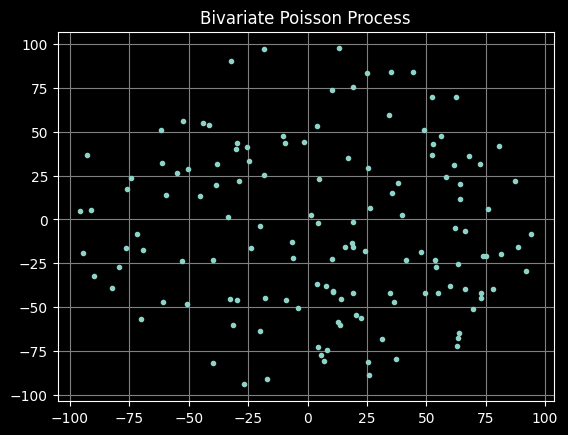

In [39]:
plt.style.use('dark_background')
plt.plot(X,Y, '.')
plt.title('Bivariate Poisson Process')
plt.grid(color='gray')
plt.show()

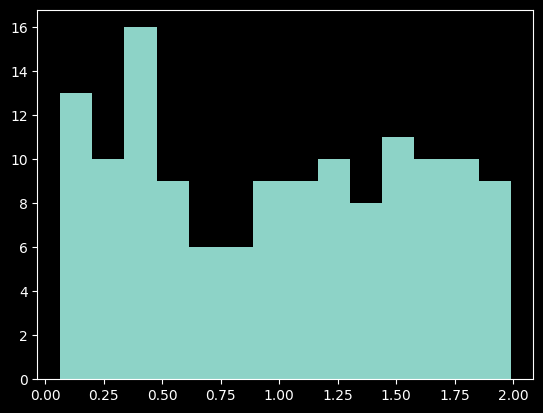

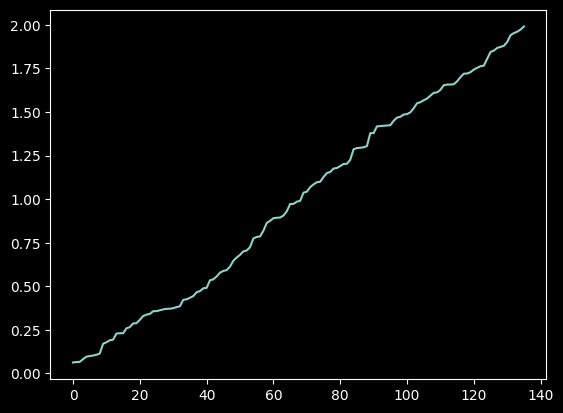

In [40]:
l = radios_unif(len(X))
plt.hist(l, bins = 14)
plt.show()

plt.plot(np.sort(l))
plt.show()

6. Implementation of the archer, Robin Hood.

Again, we need to implement the shot of the arrow fired by Robin Hood. For this, we consider that this famous archer is located at the center of Sherwood Forest. When he shoots an arrow in a random direction, it may strike and become lodged in a tree. To achieve this, we will utilize the conditions explained previously:

* Instead of shooting an arrow in a random direction, we will shoot it in the direction of the positive $x$ axis.
* We will discard all trees with negative x-coordinates
* We will compare the radius of each tree at the semicircle with the distance from the center of the tree (coordinates generated by the Poisson process) to the arrow.

The only thing left before coding these tricks will be to consider that the arrow stops when it strikes the first tree. So, Robin will need to head over to that tree to get his arrow back if he wants it.

In [41]:
@jit(nopython = True)
def disparo_flecha(X, Y, R, max_dist):
  n = len(X)

  pos = np.equal(X>0, True*np.ones(n))
  X_pos, Y_pos, R_pos = X[pos], Y[pos], R[pos]

  s = np.argsort(X_pos)
  X, Y, R = X_pos[s], Y_pos[s], R_pos[s]
  n = len(Y)

  x, y, r = 0, 0, 0
  for i in range(n):
    if abs(Y[i]) <= R[i]:
      x, y, r = X[i], Y[i], R[i]
      break
  if x != 0 or y!= 0:
    d = x - np.sqrt(r**2 - y**2)
  else:
    d = max_dist
  return x, y, d

The function disparo_flecha simulates the shot of Robin Hood's arrow, taking into account the previously mentioned "tricks."

* Inputs:
  * X: list of x tree coordinates.
  * Y: list of y tree coordinates.
  * R: list of tree radii.
  * max_dist: maximum distance the shot will travel, or the radius of the forest.
* Outputs:
  * x: x coordinate of the tree that the arrow struck.
  * y: y coordinate of the tree that the arrow struck.
  * d: distance traveled by the arrow until it struck the tree.

The arrow struck the tree with coordinates (19.351151798400018,-1.567132290781888). The arrow traveled 19.06146258736163m


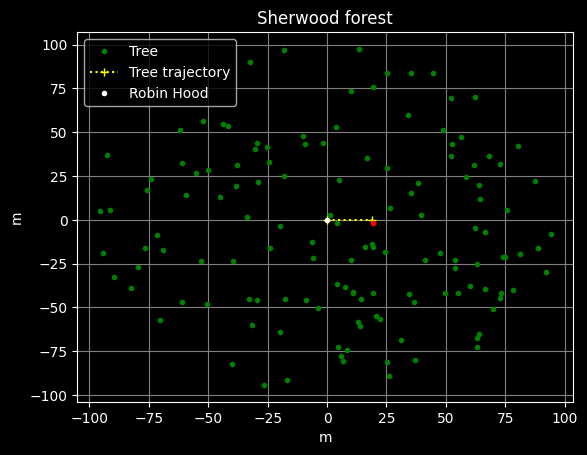

In [42]:
r_a = radios_unif(len(X))
x, y, d = disparo_flecha(X, Y, r_a, radio)

print(f'The arrow struck the tree with coordinates ({x},{y}). The arrow traveled {d}m')

plt.plot(X, Y, '.g', label='Tree')
plt.plot((0,d), (0,0), ':+', color = 'yellow', label='Tree trajectory')
plt.plot(x, y, '.r')
plt.plot(0, 0, '.w', label='Robin Hood')
plt.title('Sherwood forest')
plt.xlabel('m')
plt.ylabel('m')
plt.grid(color='gray')
plt.legend()

plt.show()

7. Now that we have the simulation of a shot, we just need to repeat the shots multiple times to observe the behavior of the process. This will allow us to reach a steady state of the simulation. To achieve this, we will use the following function.

In [43]:
def experimento(R, ρ, r_dist, n = 10**4):
  l = []
  for i in range(n):
    r, t = bosque(R, ρ)
    x = r*np.cos(t)
    y = r*np.sin(t)
    try:
      m, s = r_dist
    except:
      m = 0
      s = r_dist
    lr = radios_unif(len(x), m, s)
    _, _, d = disparo_flecha(x, y, lr, R)
    l.append(d)
  return l

In [44]:
radio = 320
densidad = 0.005
rd = (0,2)
n = 10**3

In [45]:
l = experimento(radio, densidad, rd, n)

In [46]:
m = np.mean(l)
d = np.std(l, ddof=1)
z = norm.ppf(0.975)
print(f'The 95% confidence interval is [{m - z*d/np.sqrt(n)}, {m + z*d/np.sqrt(n)}]')

The 95% confidence interval is [89.31582030775392, 100.33025503073172]


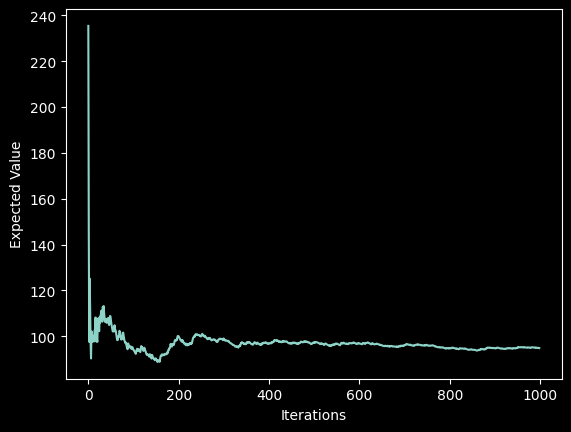

In [47]:
@jit(nopython = True)
def graf(l, p=1):
  ls = []
  for i in range(1,n):
    a = np.array(l[:i:p])
    ls.append(a.mean())

  return ls

ls = graf(l)

plt.plot(ls)
plt.xlabel('Iterations')
plt.ylabel('Expected Value')
plt.savefig('Fifth_graf')
plt.show()

In [48]:
print(f'There is a {100 * l.count(radio)/len(l)}% of arrows that travel {radio}m and do not hit any tree.')

There is a 4.5% of arrows that travel 320m and do not hit any tree.


8. Finally, we repeat the experiment multiple times to find the average of the sample means, which will be the closest estimate of the average distance the arrow will travel until it collides. Additionally, we will calculate a 95% confidence interval.

In [ ]:
def rep(R, ρ, r_dist, n = 10**2, n_rep = 10**2):
  l = []
  for i in range(n_rep):
    d = experimento(R, ρ, r_dist, n)
    D = np.array(d)
    l.append(D.mean())
  return l

In [ ]:
nr = 10**2
l = rep(radio, densidad, rd, 400, nr)

In [ ]:
m = np.mean(l)
d = np.std(l, ddof=1)
z = norm.ppf(0.975)
print(f'El intervalo de confianza del 95% es [{m - z*d/np.sqrt(nr)}, {m + z*d/np.sqrt(nr)}]')
print(f'El valor esperado de la distancia recorrida por la flecha es {m}m')

El intervalo de confianza del 95% es [93.9443357079786, 95.61375612468926]
El valor esperado de la distancia recorrida por la flecha es 94.77904591633393m


Y finalmente se muestran un par de gráficas que muestran el comportamiento del proceso de repetición de los experimentos.

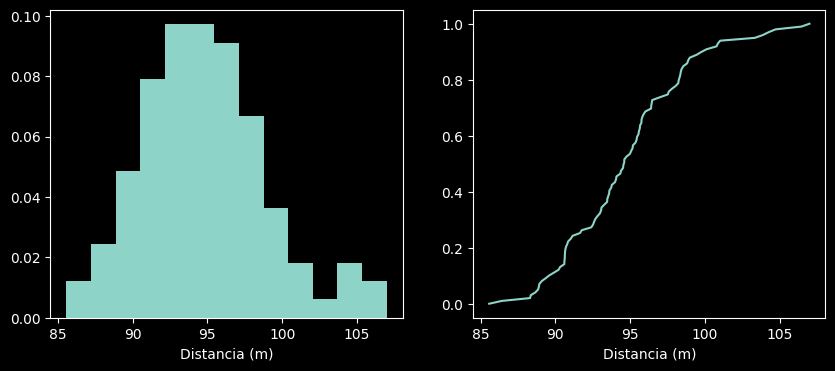

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].hist(l, bins=13, density=True)
ax[0].set_xlabel('Distancia (m)')
ax[1].plot(np.sort(l), np.linspace(0, 1, nr))
ax[1].set_xlabel('Distancia (m)')
fig.show()

#Simulación con bosque generado con proceso de Poisson, radios de los árboles constantes

1. El primer paso es definir las variables que intervienen en el problema.

Para ello, se desarrollarán las variables en coordenadas polares para luego transformarlas a coordenadas cartesianas.

* $Θ ∼ Exp[λ]$
* $R ∼ U[0,\mathcal{R}]$

donde $\mathcal{R}$ es el radio de un circulo dentro del cual se generarán las posiciones de los árboles y $λ$ es el parámetro del proceso de Poisson, lo cual para nuestro contexto será la densidad de árboles en el bosque de Sherwood.

A partir de ambos parámetros es que se generará el proceso de Poisson que expresa la ubicación de los árboles del bosque de Sherwood.

Además, se considerarán que todos los radios de los árboles son constantes, para nuestro ejemplo consideraremos que el radio será 1.

2. En adición, las funcioness de distribución de probabilida de estas dos variables son:

$$ f_Θ(θ) = λe^{-λθ}, \quad \textrm{para } θ \geq 0, \ θ\in\mathbb{R} $$
$$ f_R(r) = \frac{1}{\mathcal{R}}, \quad \textrm{para } r \in [0, \mathcal{R}], \ r\in\mathbb{R} $$

3. Y las funciones de distribución acumulada de ambas variables son:



$$ F_Θ(θ) = 1 - e^{-λθ}, \quad \textrm{para } θ \geq 0, \ θ\in\mathbb{R} $$
$$ F_R(r) = \frac{r}{\mathcal{R}}, \quad \textrm{para } r \in [0, \mathcal{R}], \ r\in\mathbb{R} $$

3. Con todo esto, podemos pasar a generar los árboles del bosque de Sherwood y realizar el lanzamiento de la flecha. Para lo cual haremos uso de la siguiente función.

In [ ]:
from random import random
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from numba import jit

In [ ]:
@jit(nopython = True)
def bosque_flecha(ρ, r = 1):
  n = 0
  X = []
  R = []
  θ = []
  while True:
    n += 1
    X.append(-np.log(random())/ρ)
    R.append(np.sqrt(sum(X)/np.pi))
    θ.append(2*np.pi*random())
    if R[-1]*abs(np.sin(θ[-1])) < r and  R[-1]*np.cos(θ[-1]) > 0:
      break

  d = R[-1] - r

  return R, θ, d

Esta función genera el proceso de Poisson bivariado. Además de generar los radios de los árboles y simula el lanzamiento de una flecha en el eje positivo $x$. El proceso de Poisson bivariado se detiene hasta que se genere un punto en el espacio (árbol) que impacte con el disparo, lo cual se comprueba la distancia del árbol con el radio de dicho árbol.

* Entradas:
  * ρ: parámetro del proceso de Poisson (λ). Densidad media de arboles en el bosque de Sherwood. Debe ser un número real positivo.
  * r: radio constante de los árboles. Debe ser un número real positivo.


* Salidas:
  * R: lista con las radios de las coordenadas polares de los arboles.
  * θ: lista con las ángulos (radianes) de las coordenadas polares de los arboles.
  * d: flotante, distacia que recorrió la flecha hasta el impacto con un árbol.

4. Ahora, veamos la función en acción. Para ello consideraremos una densidad de $0.005\frac{\textrm{árboles}}{m^2}$ para nuestra simulación y que los radios de los árboles son constantes, con radio de 1 metro.

In [ ]:
densidad = 0.005
r = 1

In [ ]:
R, θ, d = bosque_flecha(densidad, r)
X = R*np.cos(θ)
Y = R*np.sin(θ)
x, y = X[-1], Y[-1]

print(f'El disparo de la flecha recorió {d}m hasta impactar con el árbol centrado en ({x},{y}) y con radio {r}m')

El disparo de la flecha recorió 539.6422165923977m hasta impactar con el árbol centrado en (540.6421798676739,0.1992733571202431) y con radio 1m


Y a continuación se muestra una gráfica del bosque. El punto blanco es el origen, los puntos verdes los árboles y el punto rojo es el árbol con el que impactó la flecha.

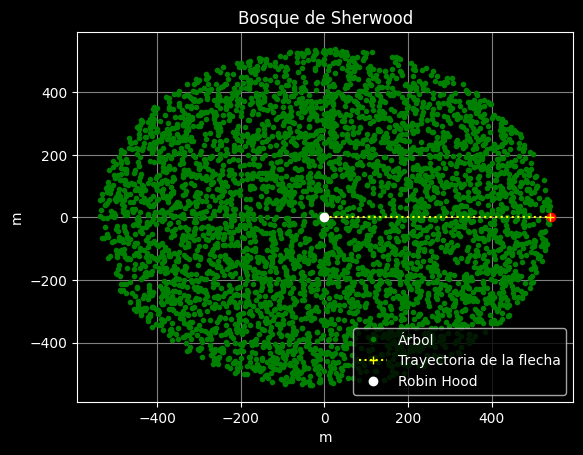

In [ ]:
plt.style.use('dark_background')
plt.plot(X,Y, '.g', label='Árbol')
plt.plot(x,y, 'or')
plt.plot((0,d), (0,0), ':+', color = 'yellow', label='Trayectoria de la flecha')
plt.plot(0,0, 'ow', label='Robin Hood')
plt.title('Bosque de Sherwood')
plt.xlabel('m')
plt.ylabel('m')
plt.grid(color='gray')
plt.legend()

plt.savefig('Sexta_graf')
plt.show()

5. Ya que tenemos la simulación de un tiro, solo queda repetir los tiros varias veces para poder observar el comportamiento del proceso gracias al método de Monte Carlo. De manera que podamos llegar al estado estable de la simulación. Para ello es que usaremos la siguiente función.

In [ ]:
@jit(nopython = True)
def experimento(ρ, r=1, n = 10**4):
  l = []
  for i in range(n):
    _, _, d = bosque_flecha(ρ,r)
    l.append(d)
  return l

Se establecen lo parámetros de entrada de la función.

In [ ]:
densidad = 0.005
r = 1
n = 10**3

Se ejecuta la función y se encuentra un intervalo de confianza para el valor esperado de la distancia recorrida por la flecha hasta el impacto.

In [ ]:
l = experimento(densidad, r, n)

In [ ]:
m = np.mean(l)
ds = np.std(l, ddof=1)
z = norm.ppf(0.975)
print(f'El intervalo de confianza del 95% es [{m - z*ds/np.sqrt(n)}, {m + z*ds/np.sqrt(n)}]')

El intervalo de confianza del 95% es [93.50138324035223, 106.12296986192257]


6. Además, para poder visualizar de mejor manera los resultados del Monte Carlo, se presenta la siguiente gráfica del comportamiento de la simulación para ilustrar el estado transitorio y el estado estable de la simulación conforme el transcurso de las iteraciones.

In [ ]:
@jit(nopython = True)
def graf(l, p=1):
  ls = []
  for i in range(1,n):
    a = np.array(l[:i:p])
    ls.append(a.mean())

  return ls

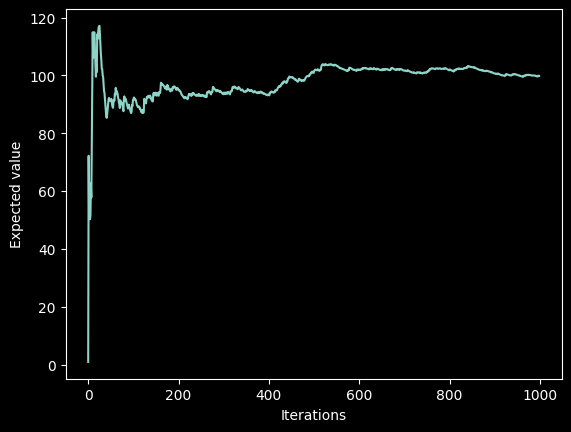

In [ ]:
ls = graf(l)

plt.plot(ls)
plt.xlabel('Iterations')
plt.ylabel('Expected value')
plt.savefig('Septima_graf')
plt.show()

7. Finalmente, repetimos el experimento varias veces para encontrar la media de medias muestrales, la cual será el valor más aproximado a la distancia media que recorrerá la flecha hasta chocar con un árbol. En adición a esto se tiene un intervalo de confianza del 95%.

In [ ]:
@jit(nopython = True)
def rep(ρ, r, n = 10**3, n_rep = 10**2):
  l = []
  for i in range(n_rep):
    d = experimento(ρ, r, n)
    D = np.array(d)
    l.append(D.mean())
  return l

In [ ]:
nr = 10**3
l = rep(densidad, r, 400, nr)

In [ ]:
m = np.mean(l)
ds = np.std(l, ddof=1)
z = norm.ppf(0.975)
print(f'El intervalo de confianza del 95% es [{m - z*ds/np.sqrt(nr)}, {m + z*ds/np.sqrt(nr)}]')
print(f'El valor esperado de la distancia recorida por la flecha es {m}m')

El intervalo de confianza del 95% es [98.4956508126372, 99.12106994633783]
El valor esperado de la distancia recorida por la flecha es 98.80836037948751m


Además, para una mejor visualización la distribución de las repeticiones de los experimentos es que agregamos las siguientes gráficas.

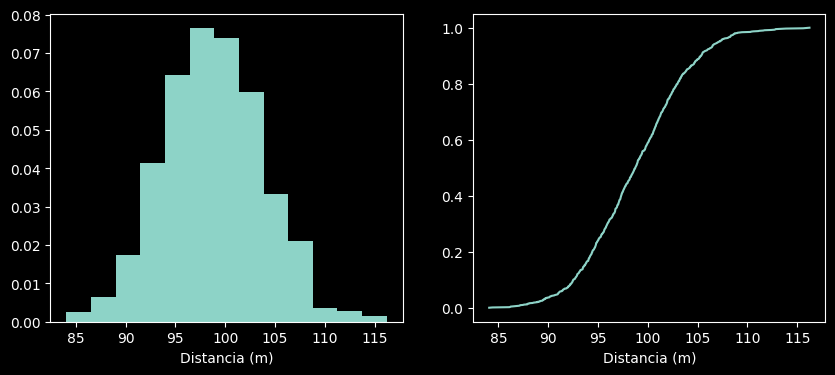

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].hist(l, bins=13, density=True)
ax[0].set_xlabel('Distancia (m)')
ax[1].plot(np.sort(l), np.linspace(0, 1, nr))
ax[1].set_xlabel('Distancia (m)')
fig.show()

#Simulación con bosque generado con proceso de Poisson, radios de los árboles uniformes

1. El primer paso es definir las variables que intervienen en el problema.

Para ello, se desarrollarán las variables en coordenadas polares para luego transformarlas a coordenadas cartesianas.

* $Θ ∼ Exp[λ]$
* $R ∼ U[0,\mathcal{R}]$

donde $\mathcal{R}$ es el radio de un circulo dentro del cual se generarán las posiciones de los árboles y $λ$ es el parámetro del proceso de Poisson, lo cual para nuestro contexto será la densidad de árboles en el bosque de Sherwood (ρ).

A partir de ambos parámetros es que se generará el proceso de Poisson que expresa la ubicación de los árboles del bosque de Sherwood.

Además, se considerará una distribución uniforme en $[a,b]$ para los radios de los árboles.

* $r_a ∼ U(a, b) $

2. En adición, las funcioness de densidad de probabilida de estas dos variables son:

$$ f_Θ(θ) = λe^{-λθ}, \quad \textrm{para } θ \geq 0, \ θ\in\mathbb{R} $$
$$ f_R(r) = \frac{1}{\mathcal{R}}, \quad \textrm{para } r \in [0, \mathcal{R}], \ r\in\mathbb{R} $$
$$ f_{r_a}(x) = \frac{1}{b-a}, \quad \textrm{para } x \in [a, b], \ x\in\mathbb{R} $$

3. Y las funciones de densidad acumulada de ambas variables son:



$$ F_Θ(θ) = 1 - e^{-λθ}, \quad \textrm{para } θ \geq 0, \ θ\in\mathbb{R} $$
$$ F_R(r) = \frac{r}{\mathcal{R}}, \quad \textrm{para } r \in [0, \mathcal{R}], \ r\in\mathbb{R} $$
$$ F_{r_a}(x) = \frac{x-a}{b-a}, \quad \textrm{para } x \in [a, b], \ x\in\mathbb{R} $$

3. Con todo esto, podemos pasar a generar los árboles del bosque de Sherwood y realizar el lanzamiento de la flecha. Para lo cual haremos uso de la siguiente función.

In [ ]:
from random import random
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from numba import jit

In [ ]:
@jit(nopython = True)
def bosque_flecha(ρ, a=0, b=2):
  n = 0
  X = []
  R = []
  θ = []
  r = []
  while True:
    n += 1
    X.append(-np.log(random())/ρ)
    R.append(np.sqrt(sum(X)/np.pi))
    θ.append(2*np.pi*random())
    r.append(a + (b-a)*random())
    if R[-1]*abs(np.sin(θ[-1])) < r[-1] and  R[-1]*np.cos(θ[-1]) > 0:
      break

  d = R[-1] - r[-1]

  return R, θ, r, d

Esta función genera el proceso de Poisson bivariado. Además de generar los radios de los árboles y simula el lanzamiento de una flecha en el eje positivo $x$. El proceso de Poisson bivariado se detiene hasta que se genere un punto en el espacio (árbol) que impacte con el disparo, lo cual se comprueba la distancia del árbol con el radio de dicho árbol.

* Entradas:
  * ρ: parámetro del proceso de Poisson (λ). Densidad media de árboles en el bosque de Sherwood. Debe ser un número real positivo.
  * a: límite inferior del intervalo de generación de números aleatorios uniformes, el rádio más pequeño que puede tener un árbol.
  * b: límite superior del intervalo de generación de números aleatorios uniformes, el rádio más grande que puede tener un árbol.


* Salidas:
  * R: lista con las radios de las coordenadas polares de los árboles.
  * θ: lista con las ángulos (radianes) de las coordenadas polares de los árboles.
  * r: lista de los rádios de los árboles.
  * d: flotante, distacia que recorrió la flecha hasta el impacto con un árbol.

4. Ahora, veamos la función en acción. Para ello consideraremos una densidad de $0.005\frac{\textrm{árboles}}{m^2}$ para nuestra simulación y que los radios de los árboles tienen una distribución uniforme en $[0,2]$.

In [ ]:
densidad = 0.005
a = 0
b = 2

In [ ]:
R, θ, r, d = bosque_flecha(densidad, a, b)
X = R*np.cos(θ)
Y = R*np.sin(θ)

x, y = X[-1], Y[-1]
print(f'El disparo de la flecha recorió {d}m hasta impactar con el árbol centrado en ({x},{y}) y con radio {r[-1]}')

El disparo de la flecha recorió 129.34063813453164m hasta impactar con el árbol centrado en (131.11745082256132,-1.498611689432857) y con radio 1.785376626851581


Y a continuación se muestra una gráfica del bosque. El punto blanco es el origen, los puntos verdes los árboles y el punto rojo es el árbol con el que impactó la flecha.

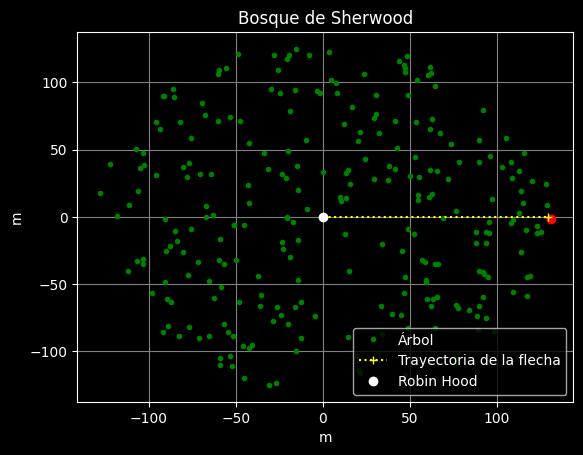

In [ ]:
plt.style.use('dark_background')
plt.plot(X,Y, '.g', label='Árbol')
plt.plot(x,y, 'or')
plt.plot((0,d), (0,0), ':+', color = 'yellow', label='Trayectoria de la flecha')
plt.plot(0,0, 'ow', label='Robin Hood')
plt.title('Bosque de Sherwood')
plt.xlabel('m')
plt.ylabel('m')
plt.grid(color='gray')
plt.legend()
plt.show()

5. Ya que tenemos la simulación de un tiro, solo queda repetir los tiros varias veces para poder observar el comportamiento del proceso gracias al método de Monte Carlo. De manera que podamos llegar al estado estable de la simulación. Para ello es que usaremos la siguiente función.

In [ ]:
@jit(nopython = True)
def experimento(ρ, a=0, b=2, n = 10**4):
  l = []
  for i in range(n):
    _, _, _, d = bosque_flecha(ρ, a, b)
    l.append(d)
  return l

La función hace el "experimento" de general un bosque aleatorio, disparar una flecha y registrar la distancia recorrida por la flecha hasta impactar con un árbol.
* Entradas:
  * ρ: flotante, parámetro del proceso de Poisson (λ). Densidad media de arboles en el bosque de Sherwood. Debe ser positivo.
  * a: flotante, límite inferior del intervalo de generación de números aleatorios uniformes, el rádio más pequeño que puede tener un árbol.
  * b: flotante, límite superior del intervalo de generación de números aleatorios uniformes, el rádio más grande que puede tener un árbol.
  * n: entero, número de repeticiones que se realizará el experimento.

* Salidas:
  * l: lista con las distancias recorridas por las flechas lanzadas en los n experimentos.

Se establecen lo parámetros de entrada de la función.

In [ ]:
densidad = 0.005
a = 0
b = 2
n = 10**3

Se ejecuta la función y se encuentra un intervalo de confianza para el valor esperado de la distancia recorrida por la flecha hasta el impacto.

In [ ]:
l = experimento(densidad, a, b, n)

In [ ]:
m = np.mean(l)
d = np.std(l, ddof=1)
z = norm.ppf(0.975)
print(f'El intervalo de confianza del 95% es [{m - z*d/np.sqrt(n)}, {m + z*d/np.sqrt(n)}]')

El intervalo de confianza del 95% es [99.50824065679694, 113.33967607020153]


6. Además, para poder visualizar de mejor manera los resultados del Monte Carlo, se presenta la siguiente gráfica del comportamiento de la simulación para ilustrar el estado transitorio y el estado estable de la simulación conforme el transcurso de las iteraciones.

In [ ]:
@jit(nopython = True)
def graf(l, p=1):
  ls = []
  for i in range(1,n):
    a = np.array(l[:i:p])
    ls.append(a.mean())

  return ls

In [ ]:
ls = graf(l)

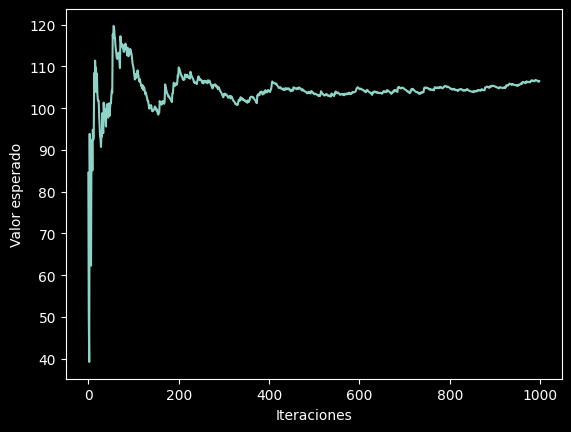

In [ ]:
plt.plot(ls)
plt.xlabel('Iteraciones')
plt.ylabel('Valor esperado')
plt.savefig('Octava_gráfica')
plt.show()

7. Finalmente, repetimos el experimento varias veces para encontrar la media de medias muestrales, la cual será el valor más aproximado a la distancia media que recorrerá la flecha hasta chocar con un árbol. Además de agregar un intervalo de confianza con un nivel de significancia de 0.05.

In [ ]:
@jit(nopython = True)
def rep(ρ, a, b, n = 10**3, n_rep = 10**2):
  l = []
  for i in range(n_rep):
    d = experimento(ρ, a, b, n)
    D = np.array(d)
    l.append(D.mean())
  return l

In [ ]:
nr=10**3
l = rep(densidad, a, b, n = 400, n_rep = nr)

In [ ]:
m = np.mean(l)
d = np.std(l, ddof=1)
z = norm.ppf(0.975)
print(f'El intervalo de confianza del 95% es [{m - z*d/np.sqrt(nr)}, {m + z*d/np.sqrt(nr)}]')
print(f'El valor esperado de la distancia recorida por la flecha es {m}m')

El intervalo de confianza del 95% es [98.51374841517104, 99.1326780881184]
El valor esperado de la distancia recorida por la flecha es 98.82321325164472m


Además, se muestran dos gráficas que nos permiten visualizar la distribución del comportamiento de los lanzamientos de flechas con el paso de las repeticiones de los experimentos.

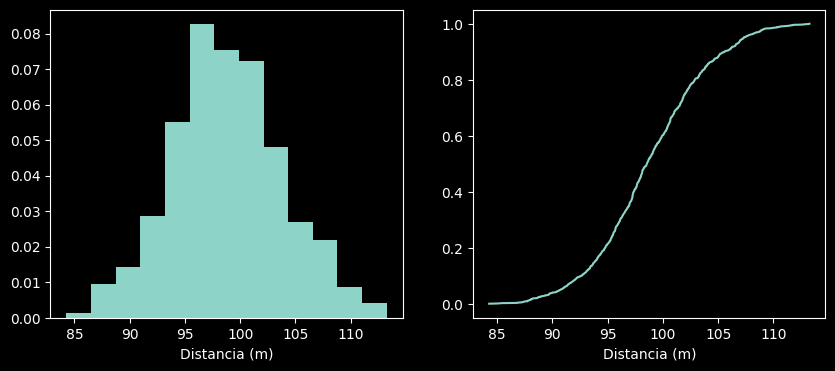

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].hist(l, bins=13, density=True)
ax[0].set_xlabel('Distancia (m)')
ax[1].plot(np.sort(l), np.linspace(0, 1, nr))
ax[1].set_xlabel('Distancia (m)')
fig.show()